# Pylops - Least squares migration (distributed)

### Author: M.Ravasi

In this notebook we will extend the Least squares Migration example to work with distributed operators.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import Spread
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from pylops_distributed.basicoperators import Spread as Spread_distr
from pylops_distributed.waveeqprocessing.lsm import _traveltime_table, Demigration
from pylops_distributed.waveeqprocessing.lsm import LSM as dLSM
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls
from pylops_distributed.utils.dottest import dottest as ddottest

In [2]:
client = pylops_distributed.utils.backend.dask(n_workers=1)
client

Client Scheduler: inproc://10.0.0.13/6118/1 Dashboard: http://localhost:58656/status,Cluster Workers: 1 Cores: 1 Memory: 8.59 GB


## 2D layered in homogenous velocity

Lets' create a model and geometry

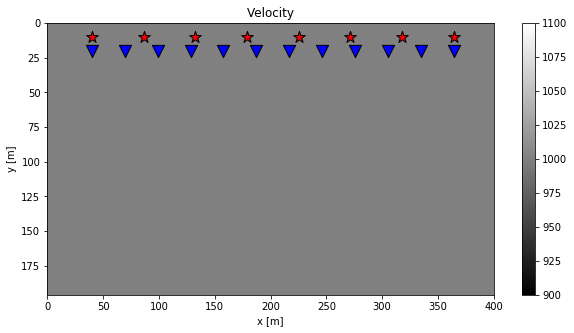

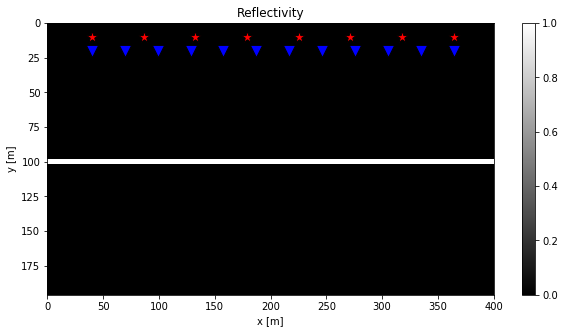

In [3]:
# Velocity Model
nx, nz = 101, 50
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
refl[:, nz//2] = 1

# Receivers
nr = 12
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 8
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

We can create now the LSM object

In [4]:
nt = 240
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

lsm = LSM(z, x, t, sources, recs, vel, wav, wavc,
           mode='eikonal')

dlsm = dLSM(z, x, t, sources, recs, vel, wav, wavc, dottest=True,
            mode='eikonal', nprocesses=len(client.ncores()), client=client)

Dot test passed, v^T(Opu)=2387.427706 - u^T(Op^Tv)=2387.427706


In [5]:
ddottest(dlsm.Demop, dlsm.Demop.shape[0], dlsm.Demop.shape[1],
         chunks=(dlsm.Demop.shape[0] // len(client.ncores()),
                 dlsm.Demop.shape[1]), raiseerror=True, verb=True);

Dot test passed, v^T(Opu)=-734.403161 - u^T(Op^Tv)=-734.403161


In [6]:
#Problem with dottest choice of chunks[0]... need to look into dda and how to find a way 
# to create it systematically... other approach is to look at table

We model the data and compute the adjoint model (=image)

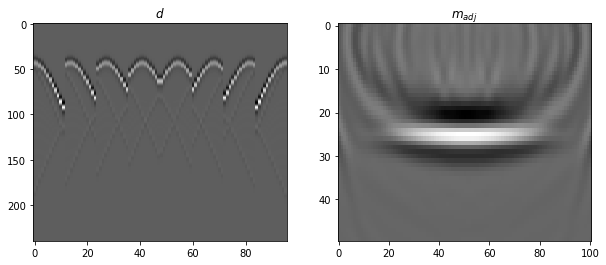

In [7]:
d = lsm.Demop.matvec(refl.ravel())
madj = lsm.Demop.rmatvec(d.ravel())

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(d.reshape(ns*nr, nt).T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight');
axs[1].imshow(madj.reshape(nx, nz).T, cmap='gray')
axs[1].set_title(r'$m_{adj}$')
axs[1].axis('tight');

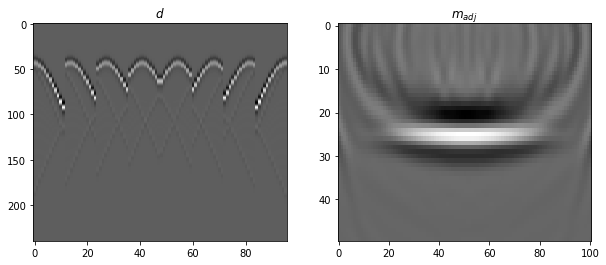

In [8]:
dda = dlsm.Demop.matvec(refl.ravel())
dcomp = dda.compute()

madjda = dlsm.Demop.rmatvec(dda.ravel())
madjcomp = madjda.compute()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(dcomp.reshape(ns*nr, nt).T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight');
axs[1].imshow(madjcomp.reshape(nx, nz).T, cmap='gray')
axs[1].set_title(r'$m_{adj}$')
axs[1].axis('tight');

In [9]:
print(np.linalg.norm(d), np.linalg.norm(dcomp-d))
print(np.linalg.norm(madj), np.linalg.norm(madjcomp-madj))

346.1942556459698 0.0
33062.453395804114 9.278910640959097e-12


Finally we invert the model

In [10]:
minv = lsm.solve(d, solver=lsqr, **dict(iter_lim=40))

def cg1(A, y, x=None, niter=10, tol=1e-5, compute=False,
       client=None):
    if x is None:
        x = np.zeros_like(y)
        r = y.copy()
    else:
        r = y - A.matvec(x)
    d = r.copy()
    kold = r.dot(r.conj())
    iit = 0
    for iit in range(niter):
        print(kold)
        if np.abs(kold) < tol:
            break
        Ad = A.matvec(d)
        a = kold / d.dot(Ad.conj())
        x = x + a * d
        r = r - a * Ad
        k = r.dot(r.conj())
        b = k / kold
        d = r + b * d
        kold = k
    return x, iit

minv, its = cg1(lsm.Demop.H * lsm.Demop, lsm.Demop.H * d.flatten(), 
                niter=40)
minv = minv.reshape(nx,nz)

In [11]:
#minvda = dlsm.solve(dda, solver=dcgls, **dict(niter=20, client=client))
minvda, its = dcgls(dlsm.Demop, dda.ravel(), niter=40, compute=True)#, client=client)
print(its)
minvcomp = minvda.reshape(nx,nz)

39


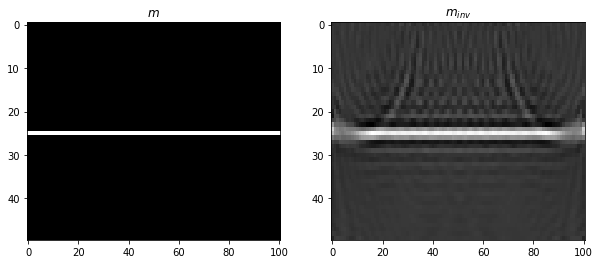

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(refl.T, cmap='gray')
axs[0].set_title(r'$m$')
axs[0].axis('tight')
axs[1].imshow(minv.T, cmap='gray')
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight');

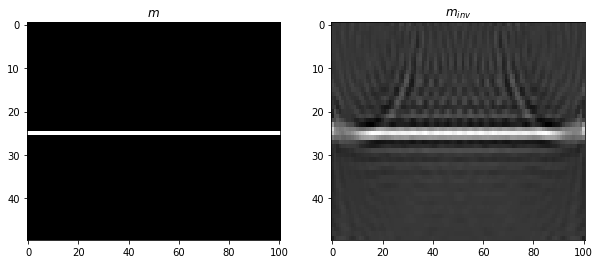

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(refl.T, cmap='gray')
axs[0].set_title(r'$m$')
axs[0].axis('tight')
axs[1].imshow(minvcomp.T, cmap='gray')
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight');